In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from pprint import pprint
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as ep

ep.update_plot_defaults()

In [2]:
tensor_normalize = transforms.Compose([transforms.ToTensor()])
#                                       transforms.Normalize(mean=[0.1307],std=[0.3081])])

MNIST_train = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',train=True,transform=tensor_normalize,download=True)
MNIST_train_sub = torch.utils.data.Subset(MNIST_train, range(2000))
MNIST_test = torchvision.datasets.MNIST(root='../datasets/MNIST_data/',train=False,transform=tensor_normalize,download=True)

In [3]:
flat_MNIST_train = []
for idx,(data,target) in enumerate(MNIST_train):
    data = data.flatten()
    target = torch.eye(len(MNIST_train.classes))[target]
    flat_MNIST_train.append((idx, data, target))

flat_MNIST_test = []
for idx,(data,target) in enumerate(MNIST_test):
    data = data.flatten()
    target = torch.eye(len(MNIST_test.classes))[target]
    flat_MNIST_test.append((idx, data, target))

data_generator = torch.Generator()
    
train_dataloader = torch.utils.data.DataLoader(flat_MNIST_train, shuffle=True, generator=data_generator)

train_sub_dataloader = torch.utils.data.DataLoader(flat_MNIST_train[:2000], shuffle=True, generator=data_generator)

test_dataloader = torch.utils.data.DataLoader(flat_MNIST_test, batch_size=10000, shuffle=False)

In [4]:
data_seed = 0
seed = 42

### Backprop (no weight contraints)

In [5]:
network_config = ut.read_from_yaml('../config/EIANN_2_hidden_mnist_backprop_relu_SGD_config.yaml')
pprint(network_config)

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

{'layer_config': {'H1': {'E': {'activation': 'relu', 'size': 500}},
                  'H2': {'E': {'activation': 'relu', 'size': 500}},
                  'Input': {'E': {'size': 784}},
                  'Output': {'E': {'activation': 'relu', 'size': 10}}},
 'projection_config': {'H1': {'E': {'Input': {'E': {'direction': 'F',
                                                    'learning_rule': 'Backprop'}}}},
                       'H2': {'E': {'H1': {'E': {'direction': 'F',
                                                 'learning_rule': 'Backprop'}}}},
                       'Output': {'E': {'H2': {'E': {'direction': 'F',
                                                     'learning_rule': 'Backprop'}}}}},
 'training_kwargs': {'backward_steps': 1,
                     'forward_steps': 1,
                     'learning_rate': 0.01,
                     'optimizer': 'SGD',
                     'tau': 1,
                     'verbose': False}}


In [6]:
data_generator.manual_seed(data_seed)
network.train(train_sub_dataloader,
              epochs=1, 
              store_history=False, 
              status_bar=True)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

tensor(0.0543)

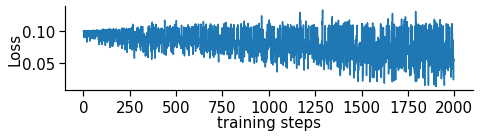

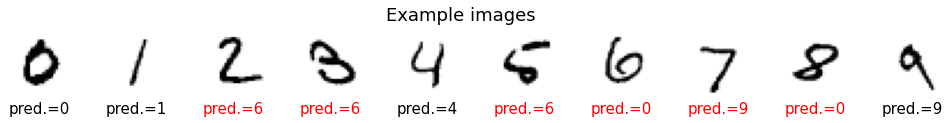

Batch accuracy = 59.41999816894531%


In [7]:
ep.plot_performance(network)
ep.plot_MNIST_examples(network, test_dataloader)
ut.compute_batch_accuracy(network, test_dataloader)

### Backprop (Dale's Law)

In [8]:
network_config = ut.read_from_yaml('../config/EIANN_2_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

In [9]:
data_generator.manual_seed(data_seed)
network.train(train_sub_dataloader, 
              epochs=1, 
              store_history=True, 
              status_bar=True)

Epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Samples:   0%|          | 0/2000 [00:00<?, ?it/s]

tensor(0.0915)

In [10]:
torch.any(network.Output.E.H2.E.weight.grad)

tensor(True)

torch.Size([2000, 8, 10])


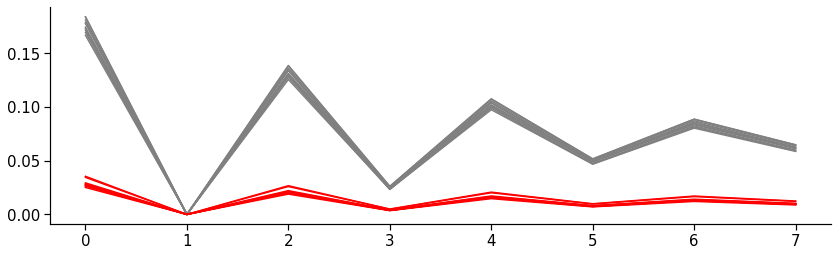

In [11]:
print(network.Output.E.activity_history.shape)

plt.figure()
for i in range(network.Output.E.size):
    plt.plot(network.Output.E.activity_history[-1,:,i], c='grey')
for i in range(network.Output.FBI.size):
    plt.plot(network.Output.FBI.activity_history[-1,:,i], c='r')

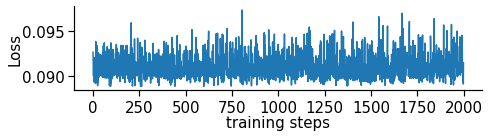

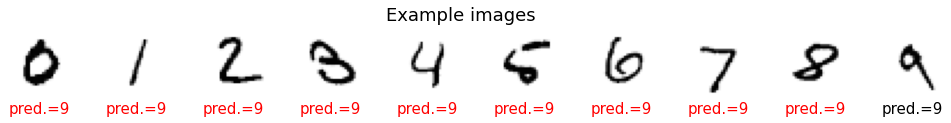

Batch accuracy = 10.09000015258789%


In [12]:
ep.plot_performance(network)
ep.plot_MNIST_examples(network, test_dataloader)
ut.compute_batch_accuracy(network, test_dataloader)

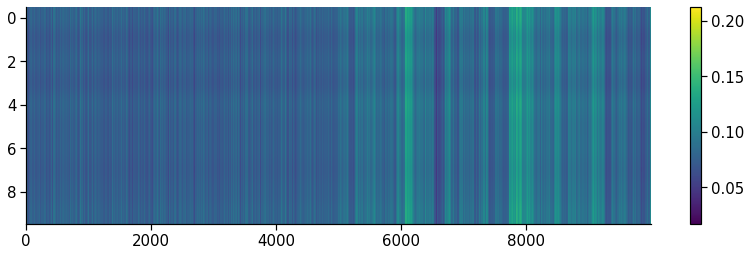

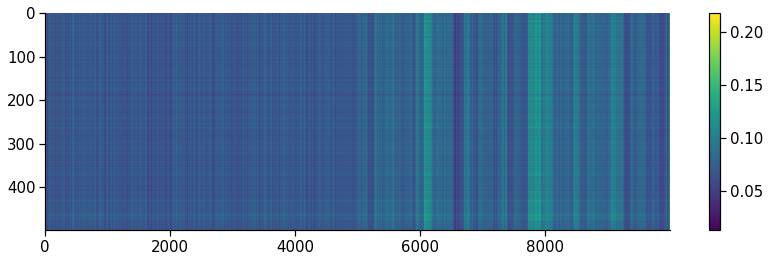

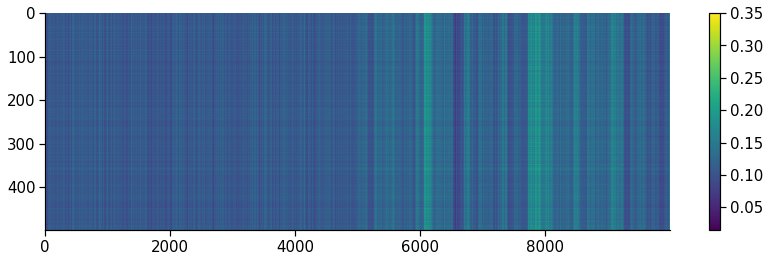

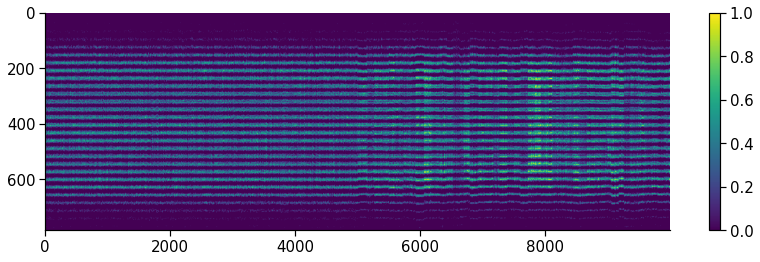

In [13]:
plt.figure()
plt.imshow(network.Output.E.activity.detach().numpy().T, aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(network.H2.E.activity.detach().numpy().T, aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(network.H1.E.activity.detach().numpy().T, aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(network.Input.E.activity.detach().numpy().T, aspect='auto')
plt.colorbar()

In [14]:
network.Output.E.activity.shape

torch.Size([10000, 10])